# Imports and loading data

In [36]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"On device : {device}\n")

bs = 32
num_workers = os.cpu_count()

train_transform = T.Compose([
    T.Resize((32, 32)),
    T.RandomRotation(12),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomPerspective(distortion_scale=0.3, p=0.3),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=num_workers)

train_sample_img, train_sample_lbl = next(iter(trainloader)); train_sample_img, train_sample_lbl = train_sample_img[0], train_sample_lbl[0]
test_sample_img, test_sample_lbl = next(iter(testloader)); test_sample_img, test_sample_lbl = test_sample_img[0], test_sample_lbl[0]

print(f"Train sample image shape : {train_sample_img.shape}\nTrain sample label shape : {train_sample_lbl.shape}\n")
print(f"Test sample image shape : {test_sample_img.shape}\nTest sample label shape : {test_sample_lbl.shape}\n")
print(f"Train sample image tensor : {train_sample_img[:5]}")

On device : cuda

Files already downloaded and verified
Files already downloaded and verified
Train sample image shape : torch.Size([3, 32, 32])
Train sample label shape : torch.Size([])

Test sample image shape : torch.Size([3, 32, 32])
Test sample label shape : torch.Size([])

Train sample image tensor : tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.0118, -1.0000, -1.0000],
         [-1.0000, -0.2627, -0.2627,  ..., -0.0510, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -0.7098,  ..., -0.9294, -0.9373, -1.0000],
         [-1.0000, -1.0000, -0.7098,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.3412, -1.0000, -1.0000],
         [-1.0000, -0.5059, -0.4824,  ..., -0.2078, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0

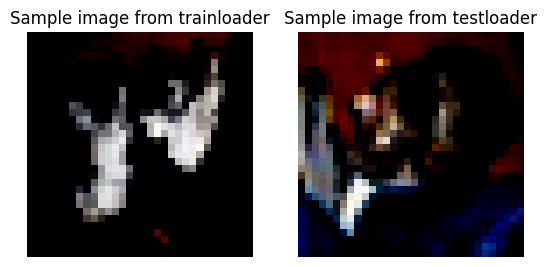

In [37]:
plt.subplot(1, 2, 1)
plt.imshow(train_sample_img.permute(1,2,0))
plt.title(f'Sample image from trainloader')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(test_sample_img.permute(1,2,0))
plt.title(f'Sample image from testloader')
plt.axis('off');

# VGG architecture

In [38]:
# The below is vgg16 implementation(for imagenet)
# but because our dataset is way more easier than imagenet and has 32x32 pixel images we will use a smaller vgg arch. with more regularization
class VGG16(nn.Module): # this is for 224x224 images
  def __init__(self):
    super().__init__()
    self.feats_layer = nn.Sequential(

        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(256, 512, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding='same'),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Linear(7*7*512, 4096),
        nn.ReLU(),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Linear(4096, 10)
    )

  def forward(self, x):
    x = self.feats_layer(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

class VGG_smaller(nn.Module): # this is for 32x32 images and has batchnorms and LeakyReLU instead of ReLU
    def __init__(self):
        super().__init__()
        self.feats_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(512),

        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(),
            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.feats_layer(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Model training and plotting predictions

In [39]:
model = VGG_smaller().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999)) # these optimizer and parameters are 'safe'

In [40]:
total_step = len(trainloader)
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0.0

    for i, (imgs, lbls) in enumerate(trainloader):
        imgs, lbls = imgs.to(device), lbls.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        train_loss_sum += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    train_loss_avg = train_loss_sum / len(trainloader)

    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0

    with torch.inference_mode():
        for val_imgs, val_lbls in testloader:
            val_imgs, val_lbls = val_imgs.to(device), val_lbls.to(device)
            val_outputs = model(val_imgs)
            val_loss = criterion(val_outputs, val_lbls)
            total_val_loss += val_loss.item()

            _, predicted = val_outputs.max(1)
            total += val_lbls.size(0)
            correct += predicted.eq(val_lbls).sum().item()

    val_accuracy = 100 * correct / total
    avg_val_loss = total_val_loss / len(testloader)

    print('Validation - Epoch [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, avg_val_loss, val_accuracy))

    print('Epoch [{}/{}], Average Train Loss: {:.4f}'
          .format(epoch+1, num_epochs, train_loss_avg))

Epoch [1/25], Step [400/1563], Train Loss: 1.6592
Epoch [1/25], Step [800/1563], Train Loss: 1.6963
Epoch [1/25], Step [1200/1563], Train Loss: 1.5037
Validation - Epoch [1/25], Test Loss: 1.1630, Test Accuracy: 58.57%
Epoch [1/25], Average Train Loss: 1.5399
Epoch [2/25], Step [400/1563], Train Loss: 1.5987
Epoch [2/25], Step [800/1563], Train Loss: 1.4603
Epoch [2/25], Step [1200/1563], Train Loss: 0.9755
Validation - Epoch [2/25], Test Loss: 0.9721, Test Accuracy: 65.79%
Epoch [2/25], Average Train Loss: 1.1756
Epoch [3/25], Step [400/1563], Train Loss: 1.2004
Epoch [3/25], Step [800/1563], Train Loss: 0.8639
Epoch [3/25], Step [1200/1563], Train Loss: 0.9692
Validation - Epoch [3/25], Test Loss: 0.8688, Test Accuracy: 70.27%
Epoch [3/25], Average Train Loss: 1.0166
Epoch [4/25], Step [400/1563], Train Loss: 0.9085
Epoch [4/25], Step [800/1563], Train Loss: 0.8496
Epoch [4/25], Step [1200/1563], Train Loss: 0.8909
Validation - Epoch [4/25], Test Loss: 0.7875, Test Accuracy: 72.71%
E

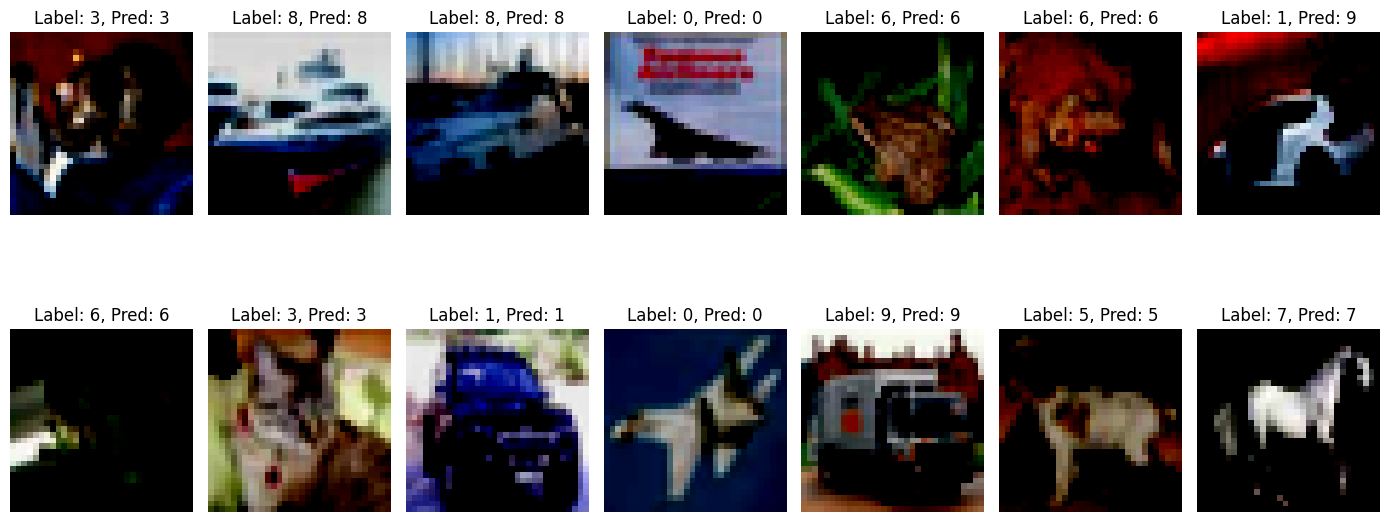

In [41]:
model.eval()

num_images = 14
data_iter = iter(testloader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

with torch.inference_mode():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

image_batch = images.cpu().numpy()
label_batch = labels.cpu().numpy()
predicted_batch = predicted.cpu().numpy()

plt.figure(figsize=(14, 7))
for idx in range(num_images):
    plt.subplot(2, 7, idx + 1)
    plt.imshow(np.transpose(image_batch[idx], (1, 2, 0)).squeeze())
    plt.title(f'Label: {label_batch[idx]}, Pred: {predicted_batch[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()